Score the output of Melodia on the full mixes in the medleydb test set against the melody2 annotations

In [1]:
import vamp
import numpy as np
import mir_eval
import os
import medleydb as mdb
import seaborn
import glob
import json
import librosa
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("../outputs/data_splits.json", 'r') as fhandle:
    dat_dict = json.load(fhandle)

In [3]:
def get_melodia_output(audio_fpath, thresh):
    y, fs = librosa.load(audio_fpath, sr=None)
    output = vamp.collect(
        y, fs, 'mtg-melodia:melodia', output='melody',
        parameters={'voicing': thresh}
    )
    hop = float(output['vector'][0])
    pitch = np.array(output['vector'][1])
    times = np.arange(0, hop*len(pitch), hop)
    return times, pitch

In [4]:
thresh_vals = np.arange(0, 1, 0.1)
mel_accuracy = {v: [] for v in thresh_vals}

for trackid in dat_dict['validate']:

    mtrack = mdb.MultiTrack(trackid)
    if mtrack.dataset_version != 'V1':
        continue
    
    print(trackid)
    mel2 = mtrack.melody2_annotation
    mel2 = np.array(mel2).T
    ref_times, ref_freqs = (mel2[0], mel2[1])

    for thresh in thresh_vals:
        est_times, est_freqs = get_melodia_output(mtrack.mix_path, thresh)
        mel_scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
        mel_accuracy[thresh].append(mel_scores['Overall Accuracy'])

BrandonWebster_DontHearAThing
BrandonWebster_YesSirICanFly
HezekiahJones_BorrowedHeart
MusicDelta_BebopJazz
MusicDelta_GriegTrolltog
MusicDelta_LatinJazz
MusicDelta_ModalJazz
SecretMountains_HighHorse
SweetLights_YouLetMeDown


In [8]:
accuracy_vals = [np.mean(mel_accuracy[thresh]) for thresh in thresh_vals]
best_thresh_idx = np.argmax(accuracy_vals)
best_thresh = thresh_vals[best_thresh_idx]

print("Best threshold is {} with an OA of {}".format(
    best_thresh, accuracy_vals[best_thresh_idx])
)

print accuracy_vals

Best threshold is 0.0 with an OA of 0.507268086718
[0.50726808671822199, 0.50280353448106396, 0.49470567001524324, 0.48167093254997073, 0.46407756316450155, 0.45472444826217884, 0.43556304212411157, 0.41798168114114476, 0.40503782348009132, 0.39745165447643738]


AClassicEducation_NightOwl


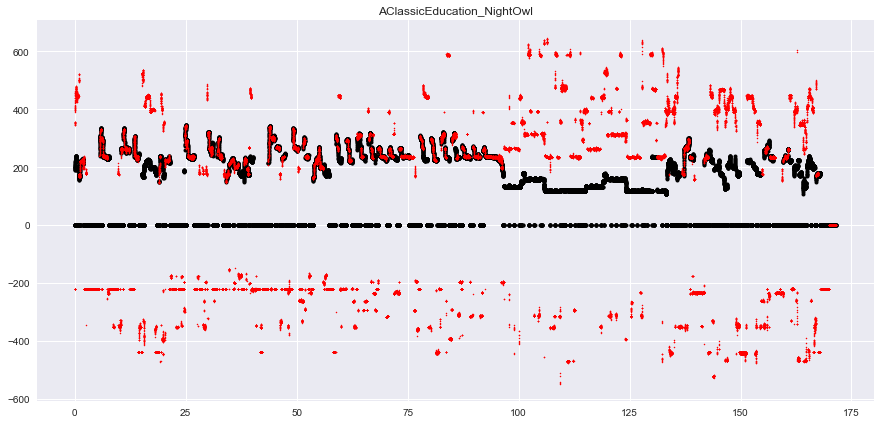

Auctioneer_OurFutureFaces


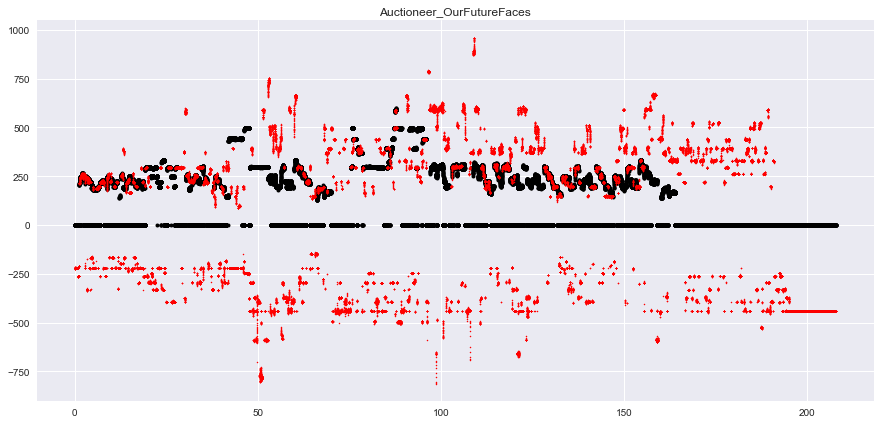

CelestialShore_DieForUs


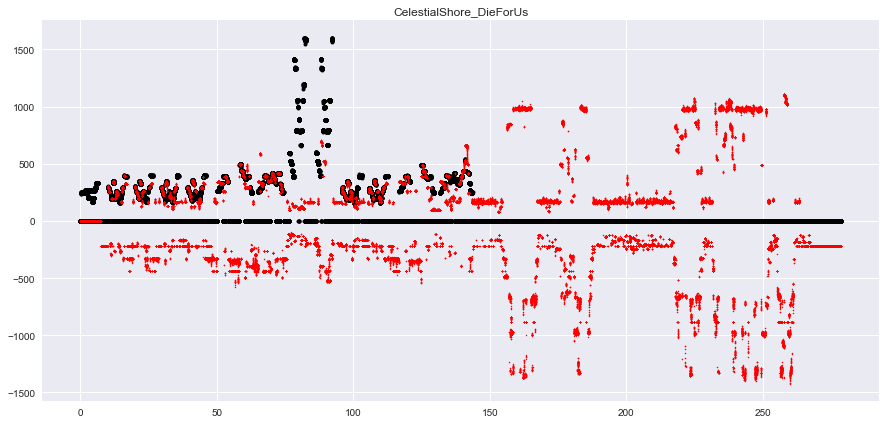

ChrisJacoby_BoothShotLincoln


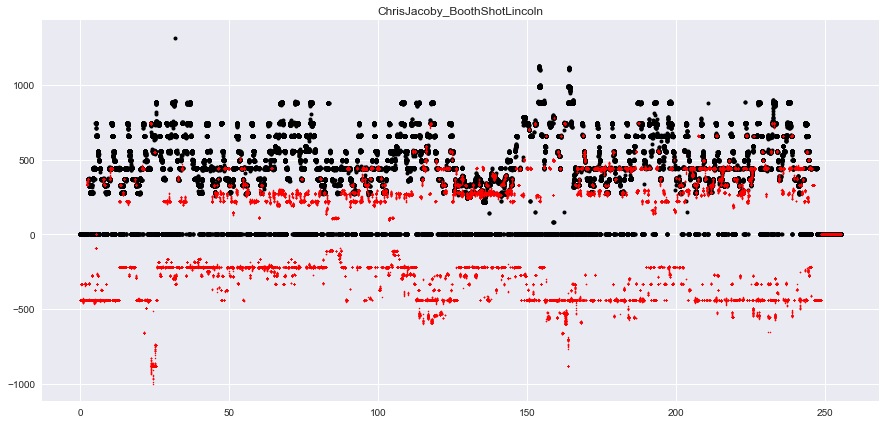

ChrisJacoby_PigsFoot


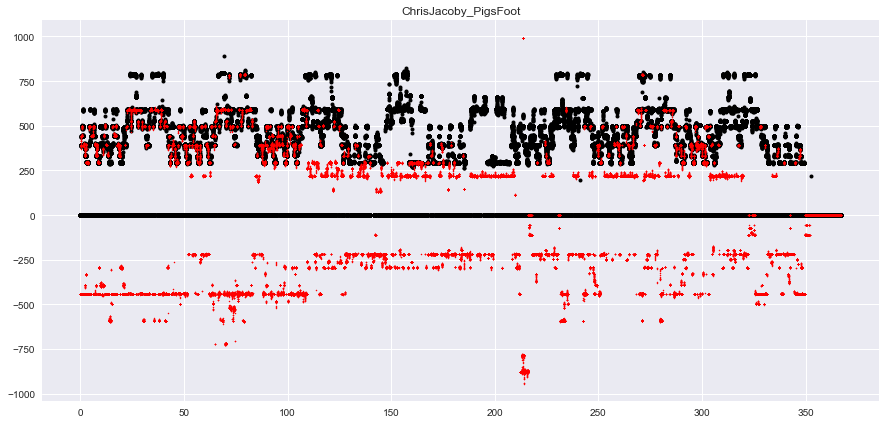

Creepoid_OldTree


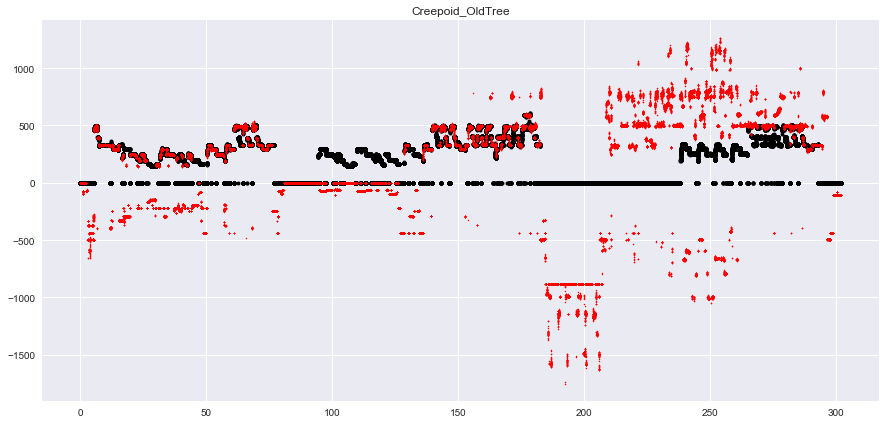

Debussy_LenfantProdigue


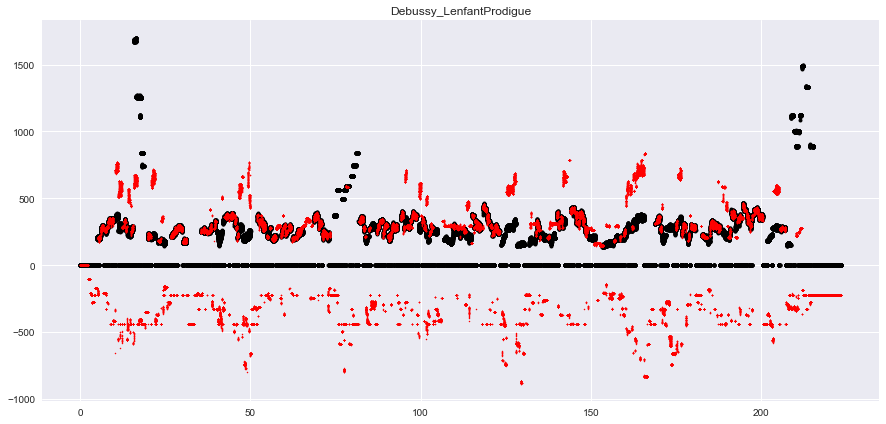

Grants_PunchDrunk
Grants_PunchDrunk
MatthewEntwistle_DontYouEver


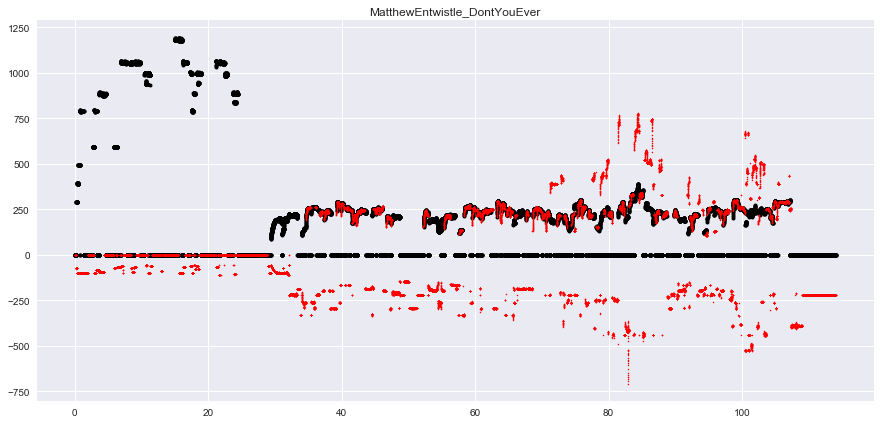

MatthewEntwistle_FairerHopes


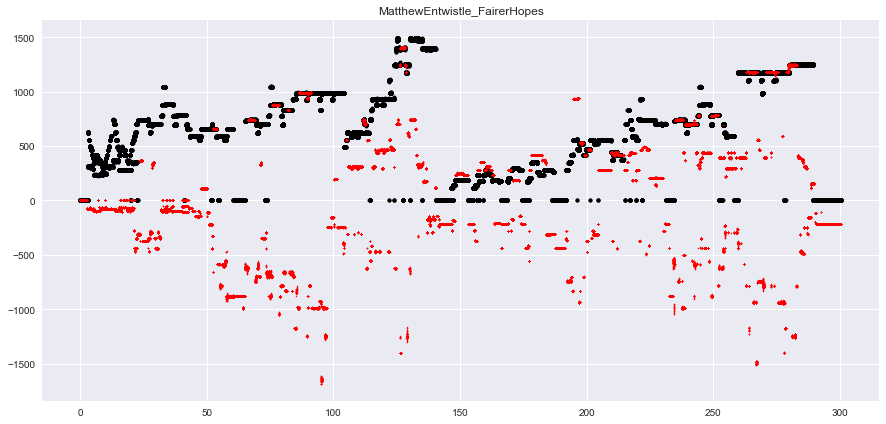

MatthewEntwistle_ImpressionsOfSaturn


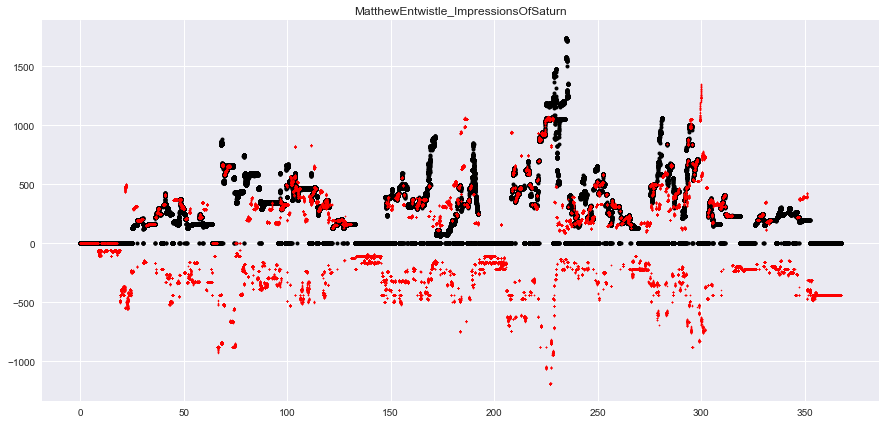

MatthewEntwistle_Lontano


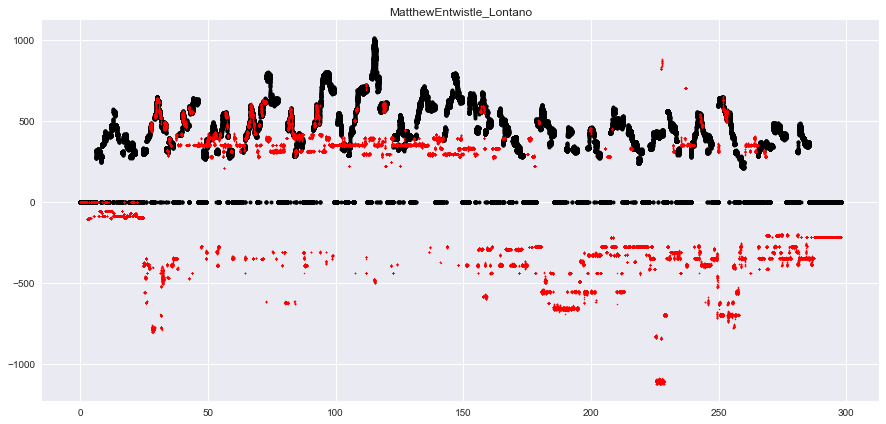

MatthewEntwistle_TheArch


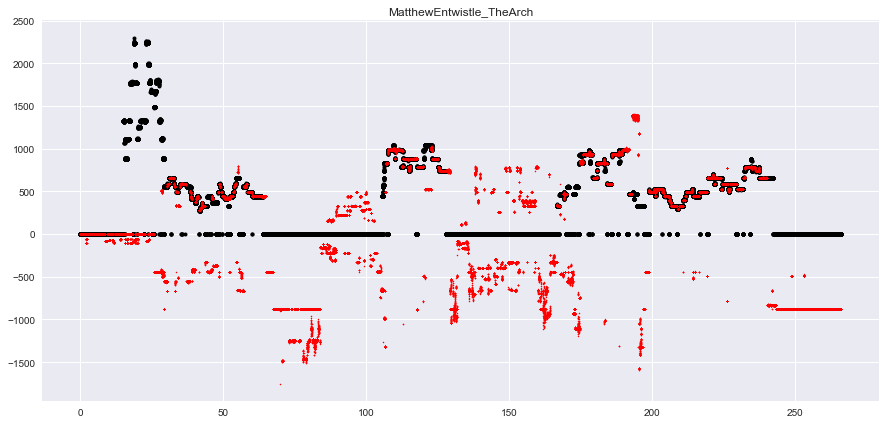

MatthewEntwistle_TheFlaxenField


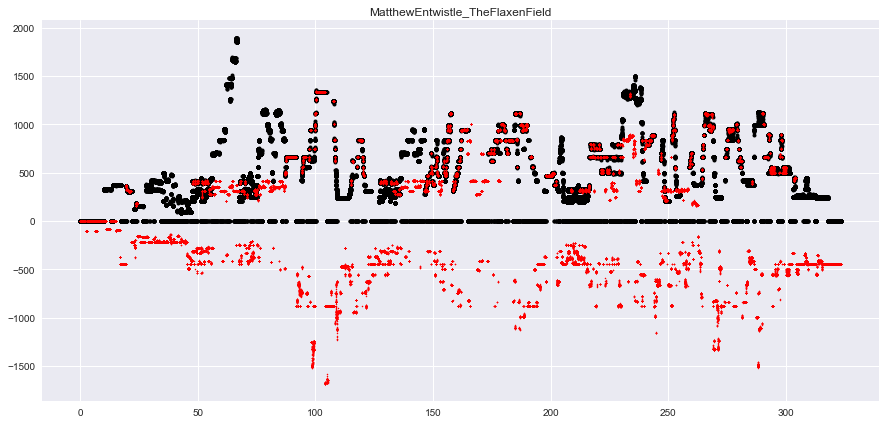

Mozart_DiesBildnis


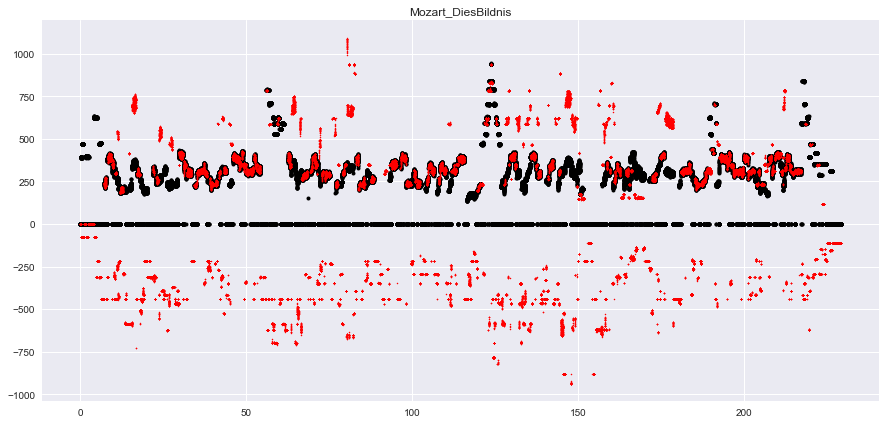

MusicDelta_FusionJazz


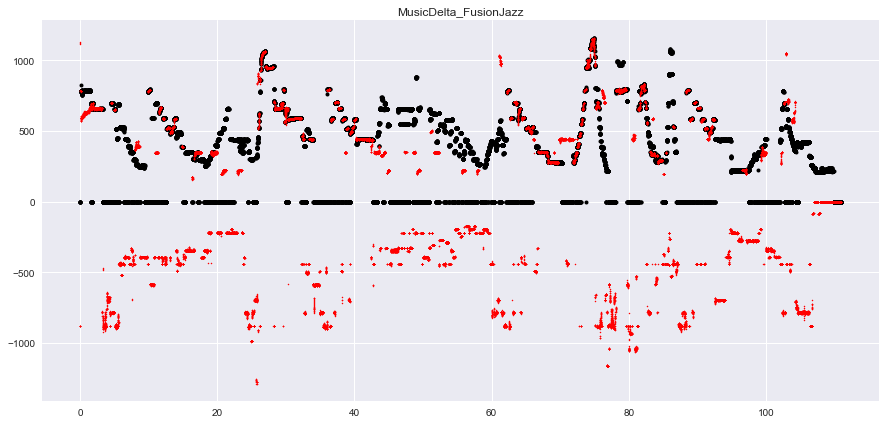

MusicDelta_Gospel


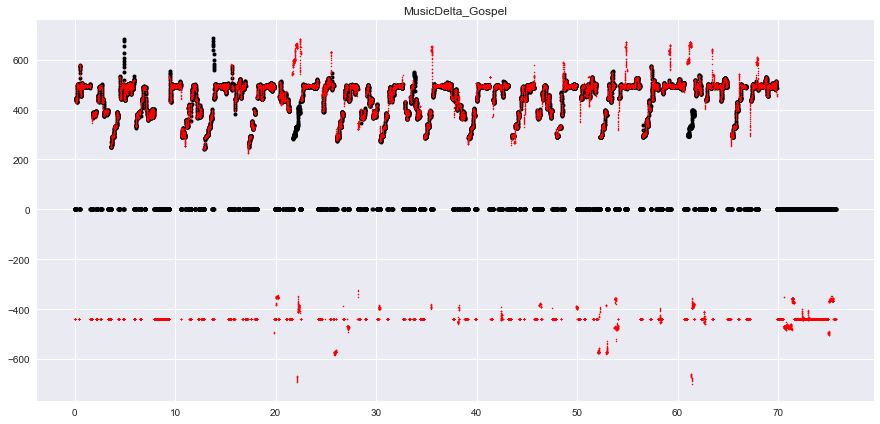

MusicDelta_Pachelbel


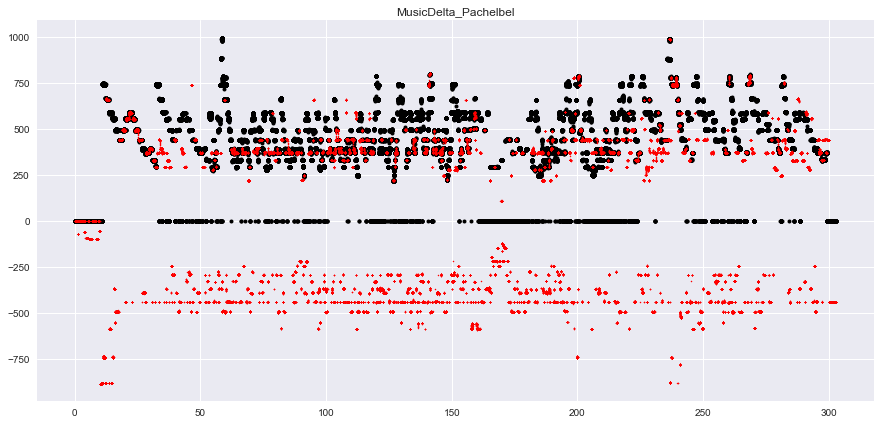

MusicDelta_SwingJazz


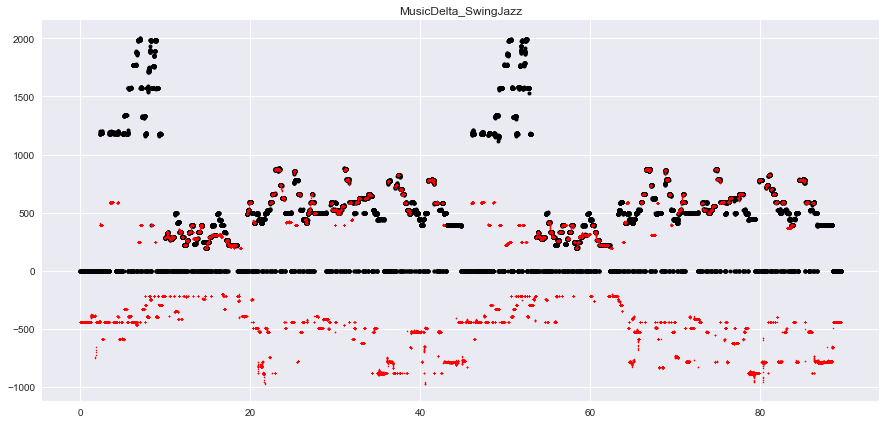

Phoenix_BrokenPledgeChicagoReel


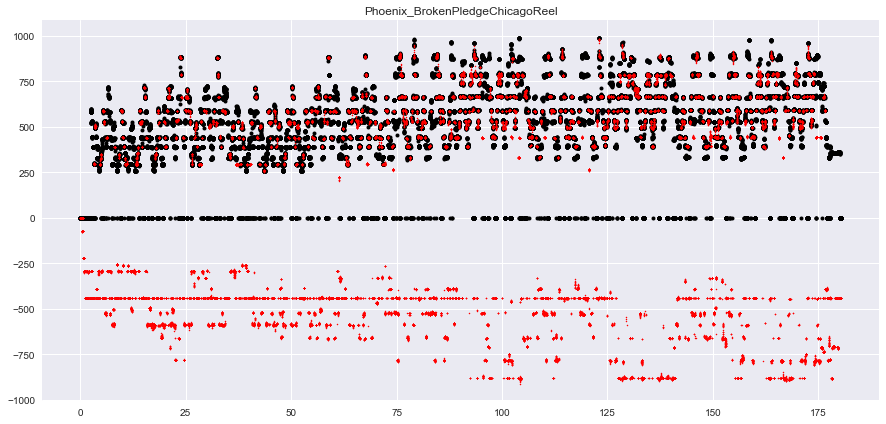

Phoenix_ColliersDaughter


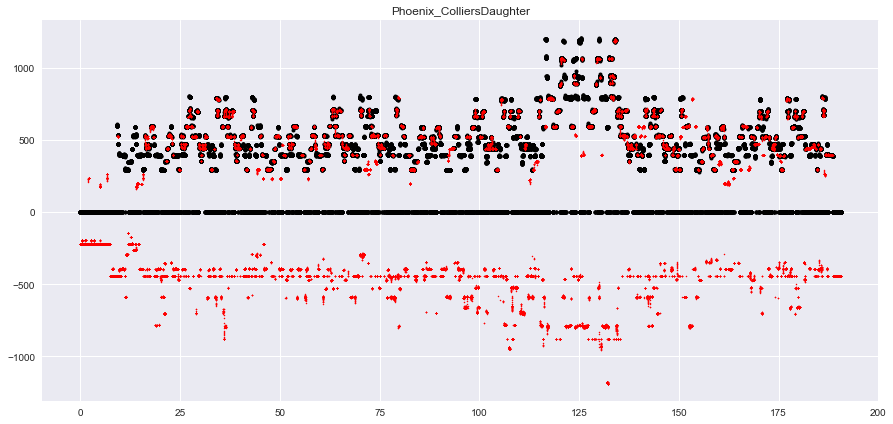

Phoenix_ElzicsFarewell


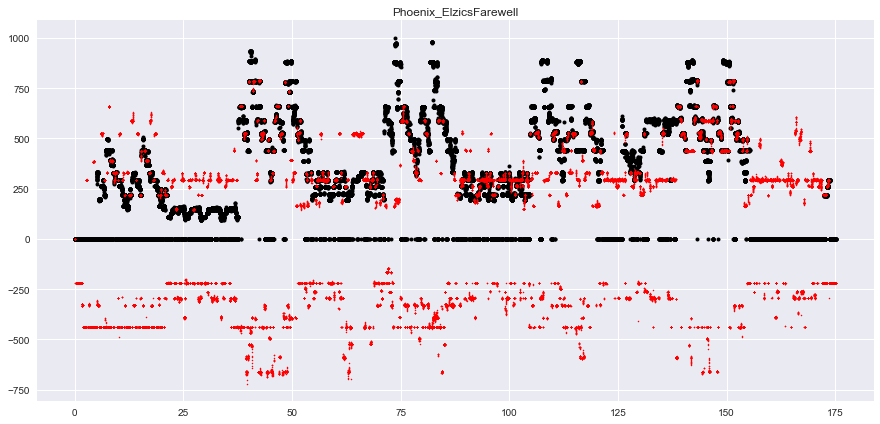

Phoenix_LarkOnTheStrandDrummondCastle


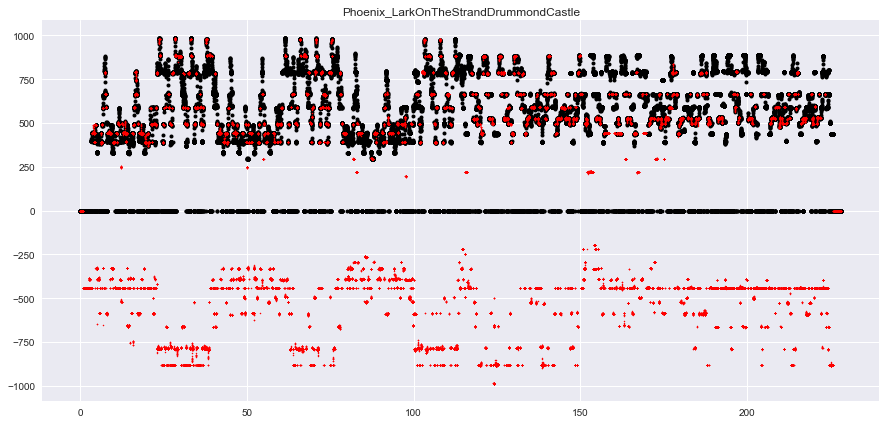

Phoenix_ScotchMorris


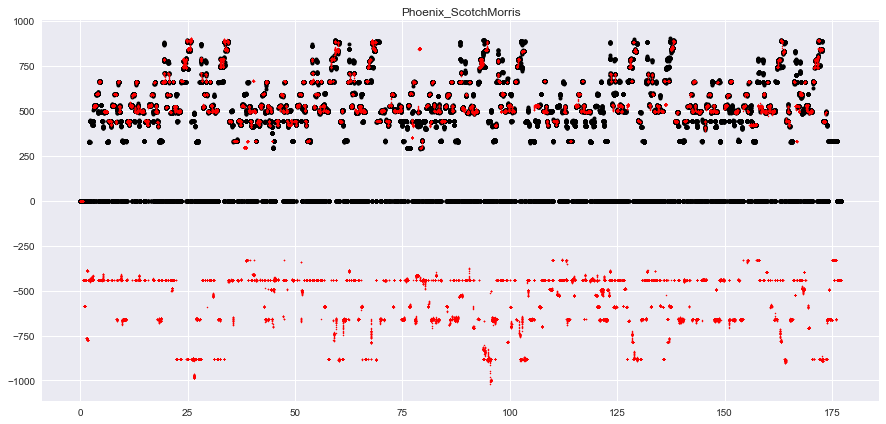

Phoenix_SeanCaughlinsTheScartaglen


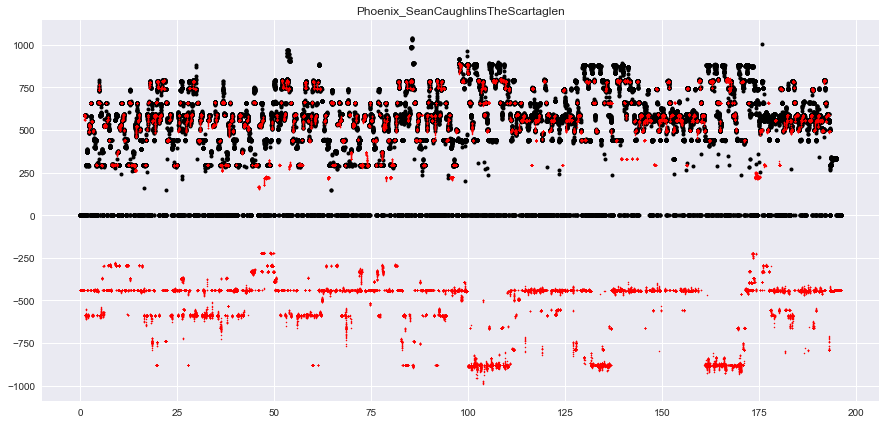

PortStWillow_StayEven


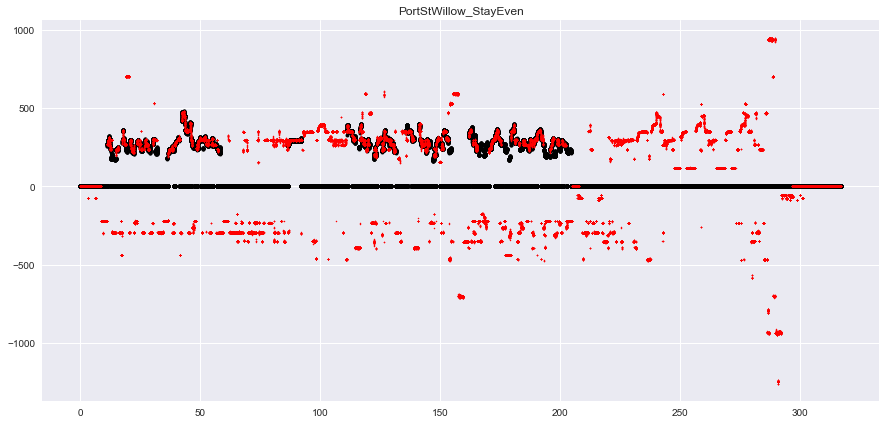

Schubert_Erstarrung


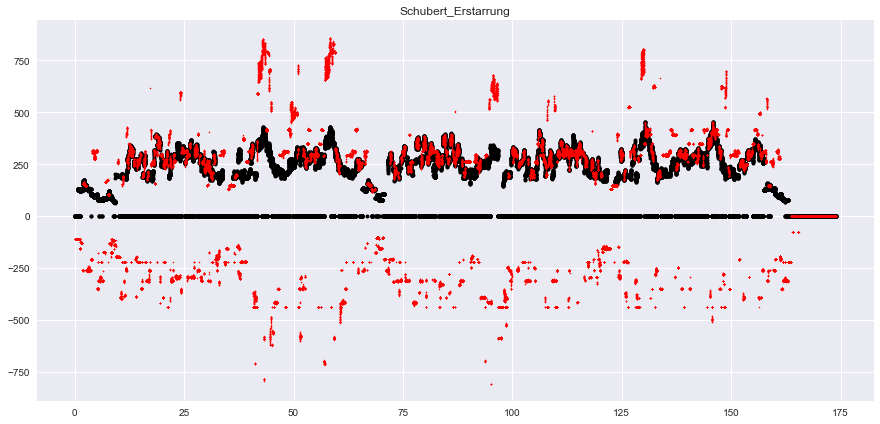

StrandOfOaks_Spacestation


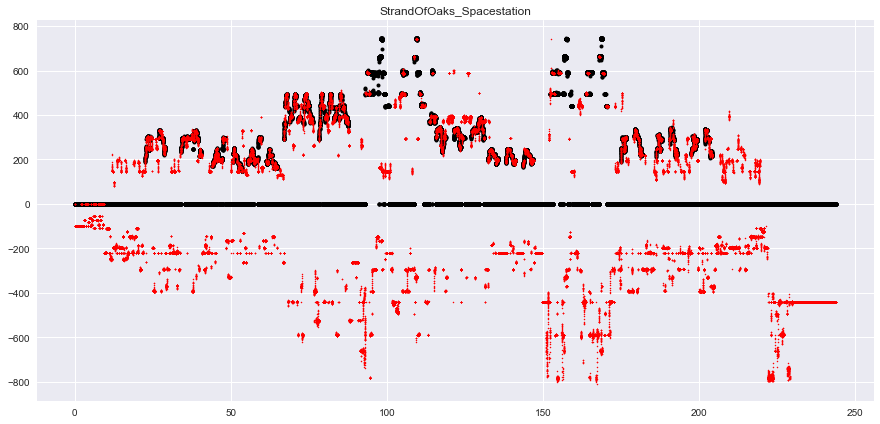

In [6]:
all_mel_scores = []
for trackid in dat_dict['test']:
    print(trackid)
    mtrack = mdb.MultiTrack(trackid)
    
    if not os.path.exists(mtrack.melody2_fpath):
        print(trackid)
        continue
    
    est_times, est_freqs = get_melodia_output(mtrack.mix_path, best_thresh)

    mel2 = mtrack.melody2_annotation
    mel2 = np.array(mel2).T
    ref_times, ref_freqs = (mel2[0], mel2[1])
    
    plt.figure(figsize=(15, 7))
    plt.title(trackid)
    plt.plot(ref_times, ref_freqs, '.k', markersize=8)
    plt.plot(est_times, est_freqs, '.r', markersize=3)
    plt.show()

    mel_scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
    all_mel_scores.append(mel_scores)

mel_scores_df_partial = pd.DataFrame(all_mel_scores)
mel_scores_df_partial.to_csv("../outputs/Melodia_scores.csv")

In [9]:
mel_scores_df_partial.describe()

,Overall Accuracy,Raw Chroma Accuracy,Raw Pitch Accuracy,Voicing False Alarm,Voicing Recall
count,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.486868,0.606311,0.476008,0.279246,0.656784
std,0.131669,0.143511,0.175466,0.116110,0.118474
min,0.274357,0.318569,0.188048,0.071076,0.512599
25%,0.392054,0.489597,0.360232,0.201246,0.559849
50%,0.501646,0.608443,0.446496,0.242126,0.643363
75%,0.542334,0.729911,0.601873,0.351802,0.726949
max,0.782555,0.817234,0.793903,0.539543,0.955698
